## Amazon Fine Food Review - KNN - Brute Force Algorithm

In [2]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



In [3]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 250000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (250000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
filtered_data['Score'].value_counts()

1    210615
0     39385
Name: Score, dtype: int64

In [5]:
demo_positive = filtered_data[filtered_data['Score']==1]
demo_negetive = filtered_data[filtered_data['Score']==0]

print(demo_positive.shape, demo_negetive.shape)

(210615, 10) (39385, 10)


In [6]:
demo_positive = demo_positive[0:25000]
demo_negetive = demo_negetive[0:39000]
print(demo_positive.shape, demo_negetive.shape)

(25000, 10) (39000, 10)


In [7]:
filtered_data = pd.DataFrame(np.vstack((demo_positive,demo_negetive)),columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])
print(filtered_data.shape)
print(type(filtered_data))

(64000, 10)
<class 'pandas.core.frame.DataFrame'>


In [8]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54263, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.7859375

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(54263, 10)


0    30817
1    23446
Name: Score, dtype: int64

In [13]:
final_score = final['Score']
final_score.shape


(54263,)

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 54263/54263 [01:26<00:00, 624.62it/s]


In [17]:
preprocessed_reviews[1500]

'yes years old addicted scooby doo fruit snacks always liked fruit snacks buy time time firsat time ever bought case good no fruit snacks even betty crocker compare try get hooked brush teeth'

## 1) Applying KNN brute force

## 1.1) Applying KNN brute force on BOW, SET 1

In [18]:
# Getting all the imports done

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from plotly.plotly import plotly as py
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample

In [19]:
final['Cleaned_Text']=preprocessed_reviews
final_review = final[['Cleaned_Text','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [20]:
# Please write all the code with proper documentation
# TIME BASED SPILTTING
# SIMPLE CROSS VALIDATION

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(34728, 1) (34728,)


In [21]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [22]:
df_post_split['Score'].value_counts()

0    18757
1    15971
Name: Score, dtype: int64

In [23]:
# Indicies of each class' observations
i_class0 = np.where(df_post_split['Score'] == 0)[0]
i_class1 = np.where(df_post_split['Score'] == 1)[0]

In [24]:
# For every observation of class 1, randomly sample from class 0 without replacement
#x_negetive_upsample = resample(x_negetive, replace = True, n_samples=17000)
x_negetive_downsample = resample(x_negetive,replace=False,n_samples=13000,random_state=123) 

In [25]:
print(x_negetive_downsample.shape, type(x_positive))

(13000, 2) <class 'pandas.core.frame.DataFrame'>


In [26]:
#df_upsample = pd.concat([x_positive,x_negetive_upsample])
df_upsample = pd.concat([x_positive,x_negetive_downsample])
type(df_upsample)

pandas.core.frame.DataFrame

In [27]:
df_upsample.head()

,Cleaned_Text,Score
1,really good idea final product outstanding use...,1
2,received shipment could hardly wait try produc...,1
8,nothing product bother link top page buy used ...,1
9,love stuff sugar free not rot gums tastes good...,1
11,chatchi favorite afternoon treat became myster...,1


In [28]:
df_upsample['Score'].value_counts()

1    15971
0    13000
Name: Score, dtype: int64

In [29]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_Train = df_upsample['Score']
print(X_Train.shape, Y_Train.shape)

(28971, 1) (28971,)


In [29]:
# Applying BOW for Vectorization
# BoW -- fit_transform on D_Train
count_vect = CountVectorizer(min_df=10) #in scikit-learn # changes done as suggested
D_Train = count_vect.fit_transform(X_Train['Cleaned_Text'])
print(" some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer ",type(D_Train))
print("the shape of BOW vectorizer ",D_Train.get_shape())
print("the number of unique words ", D_Train.get_shape()[1])

 some feature names  ['abandoned', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (28971, 6803)
the number of unique words  6803


In [30]:
# BoW -- transform on D_CV

D_Cv = count_vect.transform(X_1_cv['Cleaned_Text'])
print("the type of count vectorizer ",type(D_Cv))
print("the shape of BOW vectorizer ",D_Cv.get_shape())
print("the number of unique words ", D_Cv.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (8682, 6803)
the number of unique words  6803


In [31]:
# BoW -- transform on D_Test

D_Test = count_vect.transform(X_test['Cleaned_Text'])
print("the type of count vectorizer ",type(D_Test))
print("the shape of BOW vectorizer ",D_Test.get_shape())
print("the number of unique words ", D_Test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (10853, 6803)
the number of unique words  6803


In [32]:

n_cv = D_Cv.get_shape()[0]
n_train = D_Train.get_shape()[0]
n_test = D_Test.get_shape()[0]
print(n_train)
print(n_cv)
print(n_test)

28971
8682
10853


In [33]:
# Standardization Process
# Changes done as suggested

scaler = StandardScaler(with_mean=False)
scaler.fit(D_Train)
D_Train = scaler.transform(D_Train)
D_Cv = scaler.transform(D_Cv)
D_Test = scaler.transform(D_Test)

print(D_Train.shape)
print(D_Cv.shape)
print(D_Test.shape)

C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



(28971, 6803)
(8682, 6803)
(10853, 6803)


In [34]:
D_Train=D_Train.astype('int')
D_Cv=D_Cv.astype('int')
D_Test=D_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [35]:
# Applying Brute Force KNN

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,50))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

8682
8682

CV Accuracy for k = 1 is 59%

CV AUC for k = 1 is 0.625892%

Train Accuracy for k = 1 is 99%

Train AUC for k = 1 is 0.999000%


  4%|███▎                                                                              | 1/25 [02:24<57:51, 144.66s/it]

8682
8682

CV Accuracy for k = 3 is 59%

CV AUC for k = 3 is 0.697326%

Train Accuracy for k = 3 is 81%

Train AUC for k = 3 is 0.907941%


  8%|██████▌                                                                           | 2/25 [04:41<54:30, 142.20s/it]

8682
8682

CV Accuracy for k = 5 is 60%

CV AUC for k = 5 is 0.720839%

Train Accuracy for k = 5 is 78%

Train AUC for k = 5 is 0.881096%


 12%|█████████▊                                                                        | 3/25 [07:29<55:01, 150.08s/it]

8682
8682

CV Accuracy for k = 7 is 59%

CV AUC for k = 7 is 0.730636%

Train Accuracy for k = 7 is 75%

Train AUC for k = 7 is 0.865001%


 16%|█████████████                                                                     | 4/25 [10:10<53:36, 153.19s/it]

8682
8682

CV Accuracy for k = 9 is 57%

CV AUC for k = 9 is 0.733441%

Train Accuracy for k = 9 is 74%

Train AUC for k = 9 is 0.856148%


 20%|████████████████▍                                                                 | 5/25 [12:46<51:21, 154.08s/it]

8682
8682

CV Accuracy for k = 11 is 56%

CV AUC for k = 11 is 0.735705%

Train Accuracy for k = 11 is 72%

Train AUC for k = 11 is 0.845651%


 24%|███████████████████▋                                                              | 6/25 [15:21<48:53, 154.37s/it]

8682
8682

CV Accuracy for k = 13 is 54%

CV AUC for k = 13 is 0.733153%

Train Accuracy for k = 13 is 70%

Train AUC for k = 13 is 0.837510%


 28%|██████████████████████▉                                                           | 7/25 [17:56<46:23, 154.65s/it]

8682
8682

CV Accuracy for k = 15 is 52%

CV AUC for k = 15 is 0.731027%

Train Accuracy for k = 15 is 69%

Train AUC for k = 15 is 0.829032%


 32%|██████████████████████████▏                                                       | 8/25 [20:31<43:52, 154.86s/it]

8682
8682

CV Accuracy for k = 17 is 51%

CV AUC for k = 17 is 0.729303%

Train Accuracy for k = 17 is 67%

Train AUC for k = 17 is 0.822982%


 36%|█████████████████████████████▌                                                    | 9/25 [23:08<41:28, 155.51s/it]

8682
8682

CV Accuracy for k = 19 is 50%

CV AUC for k = 19 is 0.729088%

Train Accuracy for k = 19 is 66%

Train AUC for k = 19 is 0.816587%


 40%|████████████████████████████████▍                                                | 10/25 [25:44<38:51, 155.44s/it]

8682
8682

CV Accuracy for k = 21 is 49%

CV AUC for k = 21 is 0.727767%

Train Accuracy for k = 21 is 65%

Train AUC for k = 21 is 0.810819%


 44%|███████████████████████████████████▋                                             | 11/25 [28:17<36:08, 154.90s/it]

8682
8682

CV Accuracy for k = 23 is 48%

CV AUC for k = 23 is 0.724201%

Train Accuracy for k = 23 is 64%

Train AUC for k = 23 is 0.804265%


 48%|██████████████████████████████████████▉                                          | 12/25 [30:51<33:27, 154.40s/it]

8682
8682

CV Accuracy for k = 25 is 47%

CV AUC for k = 25 is 0.721797%

Train Accuracy for k = 25 is 63%

Train AUC for k = 25 is 0.799116%


 52%|██████████████████████████████████████████                                       | 13/25 [33:26<30:55, 154.66s/it]

8682
8682

CV Accuracy for k = 27 is 46%

CV AUC for k = 27 is 0.718152%

Train Accuracy for k = 27 is 62%

Train AUC for k = 27 is 0.793555%


 56%|█████████████████████████████████████████████▎                                   | 14/25 [36:06<28:38, 156.26s/it]

8682
8682

CV Accuracy for k = 29 is 45%

CV AUC for k = 29 is 0.715074%

Train Accuracy for k = 29 is 61%

Train AUC for k = 29 is 0.789503%


 60%|████████████████████████████████████████████████▌                                | 15/25 [38:47<26:16, 157.61s/it]

8682
8682

CV Accuracy for k = 31 is 45%

CV AUC for k = 31 is 0.714037%

Train Accuracy for k = 31 is 60%

Train AUC for k = 31 is 0.786697%


 64%|███████████████████████████████████████████████████▊                             | 16/25 [41:23<23:35, 157.27s/it]

8682
8682

CV Accuracy for k = 33 is 44%

CV AUC for k = 33 is 0.710955%

Train Accuracy for k = 33 is 60%

Train AUC for k = 33 is 0.782906%


 68%|███████████████████████████████████████████████████████                          | 17/25 [44:02<21:02, 157.76s/it]

8682
8682

CV Accuracy for k = 35 is 44%

CV AUC for k = 35 is 0.708325%

Train Accuracy for k = 35 is 59%

Train AUC for k = 35 is 0.781665%


 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [46:44<18:34, 159.15s/it]

8682
8682

CV Accuracy for k = 37 is 43%

CV AUC for k = 37 is 0.708296%

Train Accuracy for k = 37 is 59%

Train AUC for k = 37 is 0.779068%


 76%|█████████████████████████████████████████████████████████████▌                   | 19/25 [49:27<16:01, 160.33s/it]

8682
8682

CV Accuracy for k = 39 is 42%

CV AUC for k = 39 is 0.705065%

Train Accuracy for k = 39 is 58%

Train AUC for k = 39 is 0.775557%


 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [52:12<13:27, 161.55s/it]

8682
8682

CV Accuracy for k = 41 is 42%

CV AUC for k = 41 is 0.706798%

Train Accuracy for k = 41 is 58%

Train AUC for k = 41 is 0.774191%


 84%|████████████████████████████████████████████████████████████████████             | 21/25 [54:49<10:40, 160.14s/it]

8682
8682

CV Accuracy for k = 43 is 41%

CV AUC for k = 43 is 0.707036%

Train Accuracy for k = 43 is 57%

Train AUC for k = 43 is 0.772349%


 88%|███████████████████████████████████████████████████████████████████████▎         | 22/25 [57:25<07:57, 159.07s/it]

8682
8682

CV Accuracy for k = 45 is 41%

CV AUC for k = 45 is 0.706945%

Train Accuracy for k = 45 is 57%

Train AUC for k = 45 is 0.770567%


 92%|████████████████████████████████████████████████████████████████████████▋      | 23/25 [1:00:01<05:16, 158.20s/it]

8682
8682

CV Accuracy for k = 47 is 41%

CV AUC for k = 47 is 0.706992%

Train Accuracy for k = 47 is 57%

Train AUC for k = 47 is 0.769931%


 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [1:02:38<02:37, 157.66s/it]

8682
8682

CV Accuracy for k = 49 is 40%

CV AUC for k = 49 is 0.706165%

Train Accuracy for k = 49 is 57%

Train AUC for k = 49 is 0.770559%


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:05:15<00:00, 157.56s/it]


[0.6258922863682891, 0.6973255373770691, 0.7208389375112498, 0.7306362997488756, 0.7334407024549904, 0.7357046136470068, 0.7331529843954671, 0.7310269445340496, 0.7293034687652725, 0.7290880798679981, 0.7277673925552959, 0.7242013601247954, 0.7217972498315451, 0.7181524658354786, 0.715073610557915, 0.7140373319440749, 0.71095474662441, 0.7083246462615975, 0.7082957875148143, 0.7050651503737025, 0.7067982176793115, 0.7070362672834866, 0.7069447550475743, 0.7069924603228691, 0.7061653445209917]
[0.999, 0.9079406086994215, 0.8810959431276881, 0.8650014834579985, 0.8561481555511673, 0.8456510743029433, 0.8375100277907553, 0.8290323374577961, 0.8229820780934674, 0.8165872085462593, 0.8108192131892903, 0.8042650862380374, 0.7991155218834136, 0.7935554273852126, 0.7895028537300781, 0.7866967171267153, 0.7829060027068292, 0.7816649191081912, 0.7790684076426986, 0.7755565303458672, 0.774191404613169, 0.7723490822307739, 0.7705671481483266, 0.7699312672488116, 0.7705594900372309]


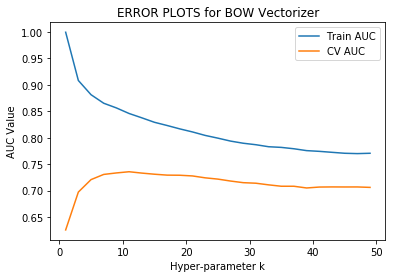

In [36]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [186]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 9
0.724


In [38]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors = 9)
test_neigh.fit(D_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


10853
10853
Algo Run Successfully on D_Test


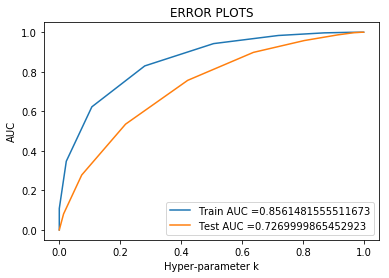

In [39]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [40]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
6410 6590 918 15053
[[ 6410  6590]
 [  918 15053]]
Test Confusion Matrix
2431 4280 422 3720
[[2431 4280]
 [ 422 3720]]


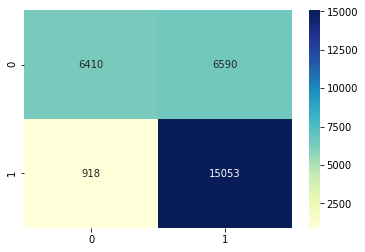

In [4]:
import seaborn as sns
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

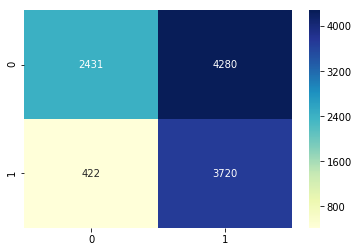

In [3]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

## 1.2) Applying KNN brute force on TFIDF, SET 2

In [30]:
# Applying Tfidf for Vectorization
# Tfidf -- fit_transform on D2_Train

tfidf_vect = TfidfVectorizer(min_df=10) #in scikit-learn
D2_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
print(" some feature names ", tfidf_vect.get_feature_names()[:10])
print('='*50)

print("the type of vectorizer ",type(D2_Train))
print("the shape of vectorizer ",D2_Train.get_shape())

 some feature names  ['abandoned', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs']
the type of vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of vectorizer  (28971, 6803)


In [31]:
# BoW -- transform on D2_CV

D2_Cv = tfidf_vect.transform(X_1_cv['Cleaned_Text'])
print("the type of count vectorizer ",type(D2_Cv))
print("the shape of vectorizer ",D2_Cv.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of vectorizer  (8682, 6803)


In [32]:
# BoW -- transform on D2_Test

D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("the type of vectorizer ",type(D2_Test))
print("the shape of vectorizer ",D2_Test.get_shape())

the type of vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of vectorizer  (10853, 6803)


In [33]:
n_cv = D2_Cv.get_shape()[0]
n_train = D2_Train.get_shape()[0]
n_test = D2_Test.get_shape()[0]
print(n_train)
print(n_cv)
print(n_test)

28971
8682
10853


In [34]:
# Standardization Process

scaler = StandardScaler(with_mean=False)
scaler.fit(D2_Train)
D2_Train = scaler.transform(D2_Train)
D2_Cv = scaler.transform(D2_Cv)
D2_Test = scaler.transform(D2_Test)

print(D2_Train.shape)
print(D2_Cv.shape)
print(D2_Test.shape)

(28971, 6803)
(8682, 6803)
(10853, 6803)


In [35]:
D2_Train=D2_Train.astype('int')
D2_Cv=D2_Cv.astype('int')
D2_Test=D2_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [36]:
# Applying Brute Force KNN

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,50))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D2_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D2_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D2_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D2_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D2_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

8682
8682

CV Accuracy for k = 1 is 50%

CV AUC for k = 1 is 0.566752%

Train Accuracy for k = 1 is 99%

Train AUC for k = 1 is 0.999038%


  4%|███▎                                                                              | 1/25 [02:15<54:16, 135.70s/it]

8682
8682

CV Accuracy for k = 3 is 46%

CV AUC for k = 3 is 0.567999%

Train Accuracy for k = 3 is 68%

Train AUC for k = 3 is 0.916395%


  8%|██████▌                                                                           | 2/25 [04:35<52:31, 137.02s/it]

8682
8682

CV Accuracy for k = 5 is 49%

CV AUC for k = 5 is 0.577761%

Train Accuracy for k = 5 is 71%

Train AUC for k = 5 is 0.806697%


 12%|█████████▊                                                                        | 3/25 [07:07<51:49, 141.33s/it]

8682
8682

CV Accuracy for k = 7 is 47%

CV AUC for k = 7 is 0.573067%

Train Accuracy for k = 7 is 67%

Train AUC for k = 7 is 0.772642%


 16%|█████████████                                                                     | 4/25 [09:38<50:29, 144.27s/it]

8682
8682

CV Accuracy for k = 9 is 45%

CV AUC for k = 9 is 0.569144%

Train Accuracy for k = 9 is 65%

Train AUC for k = 9 is 0.751236%


 20%|████████████████▍                                                                 | 5/25 [12:08<48:42, 146.14s/it]

8682
8682

CV Accuracy for k = 11 is 44%

CV AUC for k = 11 is 0.563797%

Train Accuracy for k = 11 is 63%

Train AUC for k = 11 is 0.730676%


 24%|███████████████████▋                                                              | 6/25 [14:38<46:39, 147.34s/it]

8682
8682

CV Accuracy for k = 13 is 43%

CV AUC for k = 13 is 0.558645%

Train Accuracy for k = 13 is 61%

Train AUC for k = 13 is 0.714812%


 28%|██████████████████████▉                                                           | 7/25 [17:15<45:01, 150.10s/it]

8682
8682

CV Accuracy for k = 15 is 41%

CV AUC for k = 15 is 0.557162%

Train Accuracy for k = 15 is 60%

Train AUC for k = 15 is 0.704187%


 32%|██████████████████████████▏                                                       | 8/25 [19:45<42:29, 149.99s/it]

8682
8682

CV Accuracy for k = 17 is 41%

CV AUC for k = 17 is 0.553378%

Train Accuracy for k = 17 is 59%

Train AUC for k = 17 is 0.694620%


 36%|█████████████████████████████▌                                                    | 9/25 [22:17<40:09, 150.59s/it]

8682
8682

CV Accuracy for k = 19 is 40%

CV AUC for k = 19 is 0.550031%

Train Accuracy for k = 19 is 58%

Train AUC for k = 19 is 0.687909%


 40%|████████████████████████████████▍                                                | 10/25 [24:53<38:03, 152.26s/it]

8682
8682

CV Accuracy for k = 21 is 40%

CV AUC for k = 21 is 0.548051%

Train Accuracy for k = 21 is 57%

Train AUC for k = 21 is 0.681701%


 44%|███████████████████████████████████▋                                             | 11/25 [27:22<35:19, 151.37s/it]

8682
8682

CV Accuracy for k = 23 is 39%

CV AUC for k = 23 is 0.547412%

Train Accuracy for k = 23 is 57%

Train AUC for k = 23 is 0.676239%


 48%|██████████████████████████████████████▉                                          | 12/25 [29:52<32:40, 150.79s/it]

8682
8682

CV Accuracy for k = 25 is 39%

CV AUC for k = 25 is 0.543842%

Train Accuracy for k = 25 is 56%

Train AUC for k = 25 is 0.671648%


 52%|██████████████████████████████████████████                                       | 13/25 [32:23<30:12, 151.03s/it]

8682
8682

CV Accuracy for k = 27 is 39%

CV AUC for k = 27 is 0.544087%

Train Accuracy for k = 27 is 56%

Train AUC for k = 27 is 0.668242%


 56%|█████████████████████████████████████████████▎                                   | 14/25 [35:00<27:59, 152.64s/it]

8682
8682

CV Accuracy for k = 29 is 39%

CV AUC for k = 29 is 0.545393%

Train Accuracy for k = 29 is 56%

Train AUC for k = 29 is 0.664745%


 60%|████████████████████████████████████████████████▌                                | 15/25 [37:30<25:20, 152.06s/it]

8682
8682

CV Accuracy for k = 31 is 38%

CV AUC for k = 31 is 0.548736%

Train Accuracy for k = 31 is 55%

Train AUC for k = 31 is 0.662305%


 64%|███████████████████████████████████████████████████▊                             | 16/25 [40:12<23:14, 154.92s/it]

8682
8682

CV Accuracy for k = 33 is 38%

CV AUC for k = 33 is 0.544542%

Train Accuracy for k = 33 is 55%

Train AUC for k = 33 is 0.658968%


 68%|███████████████████████████████████████████████████████                          | 17/25 [42:46<20:38, 154.78s/it]

8682
8682

CV Accuracy for k = 35 is 38%

CV AUC for k = 35 is 0.544558%

Train Accuracy for k = 35 is 55%

Train AUC for k = 35 is 0.658160%


 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [45:21<18:02, 154.66s/it]

8682
8682

CV Accuracy for k = 37 is 38%

CV AUC for k = 37 is 0.545353%

Train Accuracy for k = 37 is 55%

Train AUC for k = 37 is 0.656728%


 76%|█████████████████████████████████████████████████████████████▌                   | 19/25 [47:56<15:29, 154.93s/it]

8682
8682

CV Accuracy for k = 39 is 38%

CV AUC for k = 39 is 0.546404%

Train Accuracy for k = 39 is 55%

Train AUC for k = 39 is 0.655250%


 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [50:32<12:56, 155.25s/it]

8682
8682

CV Accuracy for k = 41 is 38%

CV AUC for k = 41 is 0.546928%

Train Accuracy for k = 41 is 55%

Train AUC for k = 41 is 0.654126%


 84%|████████████████████████████████████████████████████████████████████             | 21/25 [53:08<10:21, 155.46s/it]

8682
8682

CV Accuracy for k = 43 is 38%

CV AUC for k = 43 is 0.549651%

Train Accuracy for k = 43 is 55%

Train AUC for k = 43 is 0.652058%


 88%|███████████████████████████████████████████████████████████████████████▎         | 22/25 [55:40<07:43, 154.39s/it]

8682
8682

CV Accuracy for k = 45 is 38%

CV AUC for k = 45 is 0.549011%

Train Accuracy for k = 45 is 55%

Train AUC for k = 45 is 0.651990%


 92%|██████████████████████████████████████████████████████████████████████████▌      | 23/25 [58:13<05:08, 154.04s/it]

8682
8682

CV Accuracy for k = 47 is 38%

CV AUC for k = 47 is 0.549910%

Train Accuracy for k = 47 is 55%

Train AUC for k = 47 is 0.653419%


 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [1:00:43<02:32, 152.81s/it]

8682
8682

CV Accuracy for k = 49 is 38%

CV AUC for k = 49 is 0.546040%

Train Accuracy for k = 49 is 55%

Train AUC for k = 49 is 0.653634%


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:03:19<00:00, 153.54s/it]


[0.5667523847168789, 0.5679987796872789, 0.577761001001951, 0.5730671496762688, 0.5691442952483695, 0.5637965647377975, 0.558645096141695, 0.557161857520581, 0.5533784730127528, 0.5500313071127639, 0.5480513839381695, 0.5474121444673914, 0.5438424941765068, 0.5440867418205646, 0.5453926772374377, 0.5487363374587599, 0.5445424520017903, 0.5445577087153473, 0.5453526844552093, 0.5464042478280358, 0.5469275194485237, 0.5496513195907365, 0.5490109302573554, 0.5499099545400419, 0.5460399096555757]
[0.9990384615384615, 0.9163947659941337, 0.806696827904423, 0.7726415353790284, 0.7512356290006407, 0.7306762738232278, 0.7148124581573332, 0.7041871107728913, 0.6946199987477302, 0.6879089599899819, 0.6817013746068595, 0.6762389162087052, 0.6716478569329988, 0.6682415411587348, 0.6647449006131305, 0.6623047687394941, 0.6589684765175342, 0.6581595849207458, 0.6567276602303213, 0.6552502083102545, 0.6541255424495359, 0.6520581847868492, 0.6519900926197965, 0.6534191683965649, 0.6536343083377083]


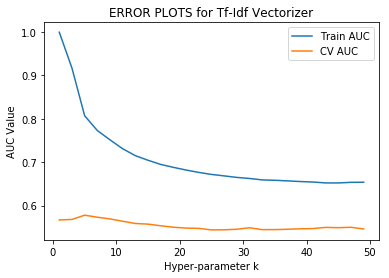

In [37]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for Tf-Idf Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [39]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 5
0.578


In [40]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors = 5)
test_neigh.fit(D2_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D2_Test')
print("="*100)


10853
10853
Algo Run Successfully on D2_Test


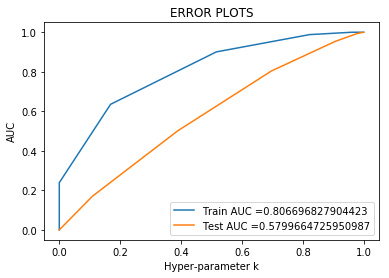

In [41]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [42]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
6293 6707 1588 14383
[[ 6293  6707]
 [ 1588 14383]]
Test Confusion Matrix
2034 4677 812 3330
[[2034 4677]
 [ 812 3330]]


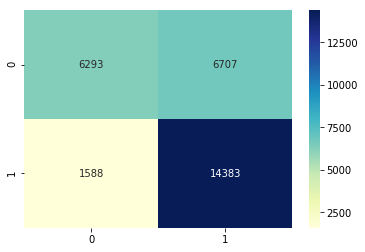

In [6]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

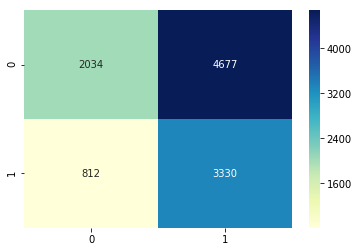

In [7]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

## 1.3) Applying KNN brute force on Avg Word2Vec, SET 3

#### We are using the previous Split of Train, CV,Test

In [32]:
# Applying Word2Vec for Vectorization of X_3_train
# Creating Word2Vec Model

list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:100])
print("="*100)

28971
[('great', 0.8195052742958069), ('amazing', 0.7860738039016724), ('decent', 0.7820311188697815), ('awesome', 0.7323476076126099), ('fantastic', 0.7189544439315796), ('ok', 0.716693639755249), ('wonderful', 0.6574519872665405), ('bad', 0.6540374159812927), ('wise', 0.6523261070251465), ('terrific', 0.6404758095741272)]
Total Words Present  10695
Sample Words :  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'surfaces', 'like', 'tv', 'screens', 'computer', 'nothing', 'bother', 'link', 'top', 'page', 'buy', 'used', 'chewing', 'gum', 'lose', 'flavor', 'overnight', 'alaska', 'stuff', 'sugar', 'free', 'not', 'rot', 'gums', 'tastes', 

In [31]:
# Creating Average Word2Vec Model for Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 28971/28971 [01:22<00:00, 353.15it/s]


28971
[-0.18343148  0.40459244  0.22405695 -0.16623469 -0.05012659  0.36548541
  0.27845646 -0.02884736  0.12364415  0.02807481  0.34402387  0.15370359
 -0.21295661  0.24957281  0.23974756  0.86386329  0.03599098 -0.0452275
  0.39128342 -0.05495582 -0.50433844 -0.40762827 -0.07607232  0.06720944
  0.38376971 -0.34133918 -0.49212575  0.67705775  0.16172356  0.62573517
 -0.40236608 -0.6358205   0.1185935  -0.24059475 -0.08607964  0.28990196
  0.11616422 -0.10175336  0.20231522  0.15476629  0.35911222 -0.20201776
 -0.55013927  0.50655071 -0.1080811  -0.01920549 -0.21956641  0.31154464
  0.1135768  -0.102149  ]


In [33]:
# Applying Word2Vec for Vectorization of X_3_cv
# Creating Word2Vec Model

list_of_sentence = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

8682


In [34]:
# Creating Average Word2Vec Vector for Cross-Validation Data

sent_vect_cv = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_cv.append(sentence_vec)
print(len(sent_vect_cv))
print(sent_vect_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 8682/8682 [00:27<00:00, 311.74it/s]


8682
[ 0.02781695  0.58314518 -0.03797786  0.19669727 -0.03793408  0.0198147
  1.29097467  0.08634523  0.19531724 -0.32600266  0.46764006 -0.42962637
 -0.15662104  0.12129142 -0.17255095  0.85984866  0.22085959  0.02714663
 -0.14212181 -0.15579586 -0.65110601  0.33387336  0.07938337 -0.07257863
  0.60698932 -0.18052846 -0.58252993  0.20605408 -0.04638014  0.06363098
 -0.51657781 -0.05163055 -0.14587512 -0.68678377  0.17427628  0.52357205
 -0.60429567  0.02821625  0.62959924  0.14200857 -0.00156858  0.04332041
 -0.49559739  0.75694533  0.05228331 -0.06870292  0.00366008 -0.66163671
 -0.22661489  0.03615093]


In [36]:
# Applying Word2Vec for Vectorization of X3_test
# Creating Word2Vec Model

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

10853


In [37]:
# Creating Average Word2Vec Vector for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 10853/10853 [00:33<00:00, 323.93it/s]


10853
[-0.13140258  0.66256223  0.30516312 -0.18445755 -0.33281532  0.60884552
  0.27796002 -0.30277244 -0.37644566  0.4191922   0.24822802 -0.13323124
 -0.09056406  0.15710755 -0.21587094  0.66926824  0.31207834  0.12192119
  0.19151678  0.30015765 -0.65829378 -0.00954082  0.44338622  0.3099545
  0.72574284 -0.07513978 -0.33195759  0.54055587  0.27577346  0.34037761
 -0.64455664 -1.05688622 -0.09416804 -0.49394421  0.18393796  0.10853573
  0.30314892 -0.23744934 -0.23303003  0.20922928  0.3012016  -0.22947545
 -0.28616402  0.19389603 -0.57434243  0.14195534 -0.07887016 -0.28537781
 -0.02159773 -0.14192012]


In [39]:
n_cv = len(sent_vect_cv)
n_train = len(sent_vect_train)
n_test = len(sent_vect_test)
print(n_train)
print(n_cv)
print(n_test)

28971
8682
10853


In [40]:
# Standardization Process

scaler = StandardScaler()
scaler.fit(sent_vect_train)
D3_Train = scaler.transform(sent_vect_train)
D3_Cv = scaler.transform(sent_vect_cv)
D3_Test = scaler.transform(sent_vect_test)

print(D3_Train.shape)
print(D3_Cv.shape)
print(D3_Test.shape)

(28971, 50)
(8682, 50)
(10853, 50)


In [42]:
D3_Train=D3_Train.astype('int')
D3_Cv=D3_Cv.astype('int')
D3_Test=D3_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [43]:
# Applying Brute Force KNN on Word2Vec Train Model

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,20))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D3_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D3_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D3_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D3_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D3_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

8682
8682

CV Accuracy for k = 1 is 61%

CV AUC for k = 1 is 0.640907%

Train Accuracy for k = 1 is 98%

Train AUC for k = 1 is 0.983446%


 10%|████████▏                                                                         | 1/10 [03:37<32:38, 217.56s/it]

8682
8682

CV Accuracy for k = 3 is 64%

CV AUC for k = 3 is 0.718981%

Train Accuracy for k = 3 is 81%

Train AUC for k = 3 is 0.900919%


 20%|████████████████▍                                                                 | 2/10 [10:16<36:16, 272.06s/it]

8682
8682

CV Accuracy for k = 5 is 65%

CV AUC for k = 5 is 0.744829%

Train Accuracy for k = 5 is 78%

Train AUC for k = 5 is 0.871217%


 30%|████████████████████████▌                                                         | 3/10 [17:03<36:27, 312.56s/it]

8682
8682

CV Accuracy for k = 7 is 66%

CV AUC for k = 7 is 0.757104%

Train Accuracy for k = 7 is 77%

Train AUC for k = 7 is 0.857096%


 40%|████████████████████████████████▊                                                 | 4/10 [23:28<33:25, 334.31s/it]

8682
8682

CV Accuracy for k = 9 is 67%

CV AUC for k = 9 is 0.766140%

Train Accuracy for k = 9 is 76%

Train AUC for k = 9 is 0.847793%


 50%|█████████████████████████████████████████                                         | 5/10 [29:57<29:13, 350.72s/it]

8682
8682

CV Accuracy for k = 11 is 67%

CV AUC for k = 11 is 0.772897%

Train Accuracy for k = 11 is 75%

Train AUC for k = 11 is 0.841065%


 60%|█████████████████████████████████████████████████▏                                | 6/10 [36:24<24:05, 361.40s/it]

8682
8682

CV Accuracy for k = 13 is 68%

CV AUC for k = 13 is 0.778328%

Train Accuracy for k = 13 is 75%

Train AUC for k = 13 is 0.837248%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [42:55<18:31, 370.50s/it]

8682
8682

CV Accuracy for k = 15 is 68%

CV AUC for k = 15 is 0.782417%

Train Accuracy for k = 15 is 75%

Train AUC for k = 15 is 0.833578%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [49:29<12:34, 377.41s/it]

8682
8682

CV Accuracy for k = 17 is 68%

CV AUC for k = 17 is 0.782909%

Train Accuracy for k = 17 is 75%

Train AUC for k = 17 is 0.830330%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [56:03<06:22, 382.42s/it]

8682
8682

CV Accuracy for k = 19 is 68%

CV AUC for k = 19 is 0.785162%

Train Accuracy for k = 19 is 75%

Train AUC for k = 19 is 0.827062%


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:02:32<00:00, 384.28s/it]


[0.6409071641880959, 0.7189808156362467, 0.7448290258077968, 0.7571043139086764, 0.7661395696496178, 0.772896779302159, 0.778328057146713, 0.7824174172885601, 0.7829085768924621, 0.7851617466850443]
[0.9834463209759997, 0.9009188192059647, 0.8712168088313914, 0.8570956300602536, 0.8477930287106921, 0.8410651011689455, 0.8372475351960043, 0.8335778935859707, 0.8303302957764794, 0.8270615466494561]


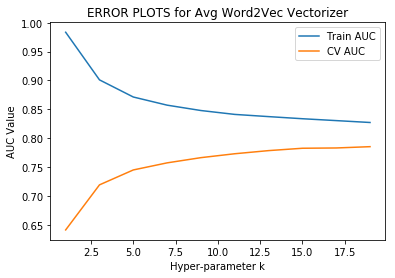

In [44]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for Avg Word2Vec Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [46]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 19
0.785


In [53]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors = 19)
test_neigh.fit(D3_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D3_Test')
print("="*100)

10853
10853
Algo Run Successfully on D3_Test


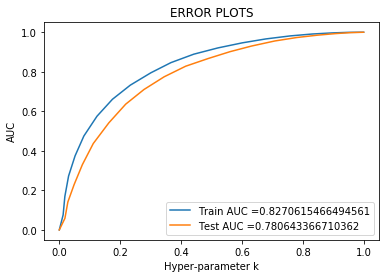

In [54]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [55]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
8231 4769 2454 13517
[[ 8231  4769]
 [ 2454 13517]]
Test Confusion Matrix
3925 2786 712 3430
[[3925 2786]
 [ 712 3430]]


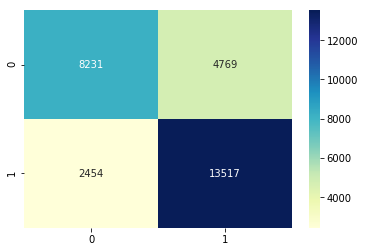

In [9]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

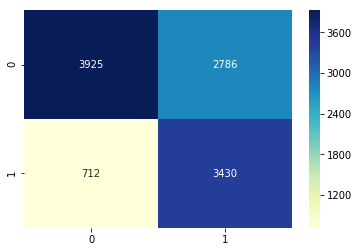

In [10]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

 ## 1.4) Applying KNN brute force on Tf-Idf Weighted Avg Word2Vec, SET 4

We are using the previous splitting and the Word2Vec Model here. We are not training the Word2Vec Model again here.

In [29]:
# Tf-Idf Model Creation

tfidf_vect = TfidfVectorizer(min_df=10) #in scikit-learn
D4_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
print(" some feature names ", tfidf_vect.get_feature_names()[:10])
print('='*50)

print("the type of vectorizer ",type(D4_Train))
print("the shape of vectorizer ",D4_Train.get_shape())

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

 some feature names  ['abandoned', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs']
the type of vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of vectorizer  (28971, 6803)


In [30]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

28971


In [33]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|███████████████████████████████████████████████████████████████████████████| 28971/28971 [03:42<00:00, 130.44it/s]


28971


In [37]:
# Splitting the Cross-Validation Data into sentences

list_of_sentence = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

8682


In [38]:
# Tf-Idf Vector Creation for Cross Validation Data

D4_Cv = tfidf_vect.transform(X_1_cv['Cleaned_Text'])
print(" some feature names ", tfidf_vect.get_feature_names()[:10])
print('='*50)

print("the type of vectorizer ",type(D4_Cv))
print("the shape of vectorizer ",D4_Cv.get_shape())

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

 some feature names  ['abandoned', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs']
the type of vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of vectorizer  (8682, 6803)


In [39]:
# Tf-Idf Weighted Word2Vec for Cross-Validation Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_cv = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_cv.append(sent_vec)
print(len(tfidf_w2v_cv))

100%|█████████████████████████████████████████████████████████████████████████████| 8682/8682 [01:06<00:00, 130.61it/s]


8682


In [41]:
# Splitting the Test Data into sentences

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

10853


In [42]:
# Tf-Idf Vector Creation for Test Data

D4_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print(" some feature names ", tfidf_vect.get_feature_names()[:10])
print('='*50)

print("the type ",type(D4_Test))
print("the shape of vectorizer ",D4_Test.get_shape())

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

 some feature names  ['abandoned', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs']
the type  <class 'scipy.sparse.csr.csr_matrix'>
the shape of vectorizer  (10853, 6803)


In [43]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|███████████████████████████████████████████████████████████████████████████| 10853/10853 [01:20<00:00, 135.22it/s]


10853


In [45]:
n_cv = len(tfidf_w2v_cv)
n_train = len(tfidf_w2v_train)
n_test = len(tfidf_w2v_test)
print(n_train)
print(n_cv)
print(n_test)

28971
8682
10853


In [47]:
# Standardization Process

scaler = StandardScaler()
scaler.fit(tfidf_w2v_train)
D3_Train = scaler.transform(tfidf_w2v_train)
D3_Cv = scaler.transform(tfidf_w2v_cv)
D3_Test = scaler.transform(tfidf_w2v_test)

print(D3_Train.shape)
print(D3_Cv.shape)
print(D3_Test.shape)

(28971, 50)
(8682, 50)
(10853, 50)


In [48]:
D3_Train=D3_Train.astype('int')
D3_Cv=D3_Cv.astype('int')
D3_Test=D3_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [49]:
# Applying Brute Force KNN on Tf_Idf Weighted Word2Vec Train Model

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,20))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D3_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D3_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D3_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D3_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D3_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

8682
8682

CV Accuracy for k = 1 is 59%

CV AUC for k = 1 is 0.626297%

Train Accuracy for k = 1 is 97%

Train AUC for k = 1 is 0.968083%


 10%|████████▏                                                                         | 1/10 [03:33<32:04, 213.84s/it]

8682
8682

CV Accuracy for k = 3 is 60%

CV AUC for k = 3 is 0.687543%

Train Accuracy for k = 3 is 80%

Train AUC for k = 3 is 0.887731%


 20%|████████████████▍                                                                 | 2/10 [09:37<34:29, 258.67s/it]

8682
8682

CV Accuracy for k = 5 is 61%

CV AUC for k = 5 is 0.709031%

Train Accuracy for k = 5 is 76%

Train AUC for k = 5 is 0.850615%


 30%|████████████████████████▌                                                         | 3/10 [16:03<34:38, 296.91s/it]

8682
8682

CV Accuracy for k = 7 is 62%

CV AUC for k = 7 is 0.723627%

Train Accuracy for k = 7 is 75%

Train AUC for k = 7 is 0.832819%


 40%|████████████████████████████████▊                                                 | 4/10 [22:12<31:50, 318.47s/it]

8682
8682

CV Accuracy for k = 9 is 62%

CV AUC for k = 9 is 0.732430%

Train Accuracy for k = 9 is 74%

Train AUC for k = 9 is 0.821658%


 50%|█████████████████████████████████████████                                         | 5/10 [28:47<28:28, 341.68s/it]

8682
8682

CV Accuracy for k = 11 is 62%

CV AUC for k = 11 is 0.737795%

Train Accuracy for k = 11 is 73%

Train AUC for k = 11 is 0.814337%


 60%|█████████████████████████████████████████████████▏                                | 6/10 [35:25<23:54, 358.51s/it]

8682
8682

CV Accuracy for k = 13 is 63%

CV AUC for k = 13 is 0.741560%

Train Accuracy for k = 13 is 73%

Train AUC for k = 13 is 0.808557%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [42:05<18:32, 370.96s/it]

8682
8682

CV Accuracy for k = 15 is 63%

CV AUC for k = 15 is 0.745919%

Train Accuracy for k = 15 is 73%

Train AUC for k = 15 is 0.804243%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [49:01<12:49, 384.57s/it]

8682
8682

CV Accuracy for k = 17 is 63%

CV AUC for k = 17 is 0.746807%

Train Accuracy for k = 17 is 72%

Train AUC for k = 17 is 0.800843%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [55:46<06:30, 390.61s/it]

8682
8682

CV Accuracy for k = 19 is 64%

CV AUC for k = 19 is 0.748300%

Train Accuracy for k = 19 is 72%

Train AUC for k = 19 is 0.798125%


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:02:24<00:00, 392.92s/it]


[0.6262965612321187, 0.6875425904901202, 0.7090311947627741, 0.7236271019137808, 0.7324298890909843, 0.7377952882220359, 0.741559685974206, 0.7459190955550967, 0.746806817529762, 0.7482996476877076]
[0.9680831699763515, 0.887730954663019, 0.850614948729187, 0.8328187026485505, 0.8216580846052701, 0.8143372506899524, 0.8085574478742721, 0.8042429017979703, 0.8008426643483622, 0.7981253497926531]


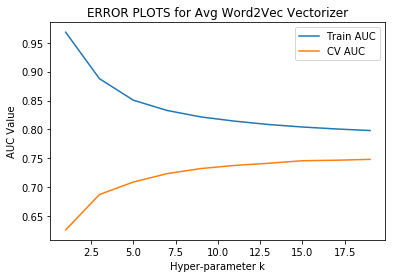

In [50]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for Avg Word2Vec Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [52]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 19
0.748


In [63]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors = 15)
test_neigh.fit(D3_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D3_Test')
print("="*100)

10853
10853
Algo Run Successfully on D3_Test


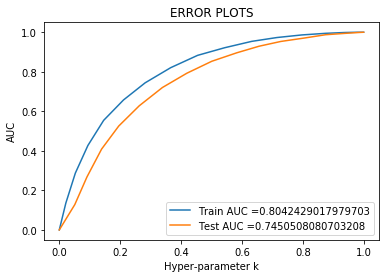

In [64]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [65]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
7092 5908 1867 14104
[[ 7092  5908]
 [ 1867 14104]]
Test Confusion Matrix
3348 3363 608 3534
[[3348 3363]
 [ 608 3534]]


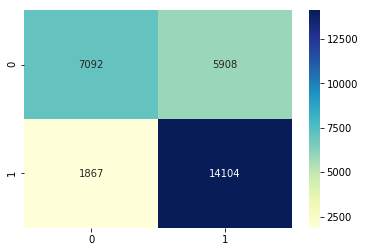

In [12]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

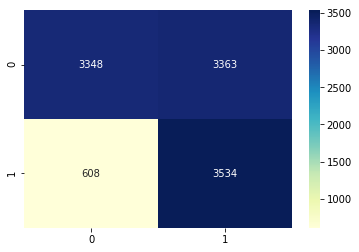

In [13]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

## Conclusion for Brute Force

In [1]:
# Importing Pretty Table
from prettytable import PrettyTable

In [6]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter Value','AUC']
x.add_row(['BOW','K = 9','0.73'])
x.add_row(['Tf-Idf','K = 5 ','0.58'])
x.add_row(['Avg Word2Vec','K = 19','0.78'])
x.add_row(['Tf-Idf Weighted Avg Word2Vec','K = 15','0.75'])

print(x)

+------------------------------+-----------------------+------+
|          Vectorizer          | Hyper-Parameter Value | AUC  |
+------------------------------+-----------------------+------+
|             BOW              |         K = 9         | 0.73 |
|            Tf-Idf            |         K = 5         | 0.58 |
|         Avg Word2Vec         |         K = 19        | 0.78 |
| Tf-Idf Weighted Avg Word2Vec |         K = 15        | 0.75 |
+------------------------------+-----------------------+------+


##### From the above table we see that for Amazon Fine Food Review Dataset with 250k datapoints as sample , KNN runs best for Avg Word2Vec Vectorizer  at K = 19 giving AUC value of 0.78 (approx). 

##### We have upsampled the training set explicitly.

##### We have used Time Based Splitting and Simple Cross-Validation to break the data in Train , CV and Test part. These findings are from Brute Force KNN Method. 